In [1]:
using Revise

using RigidBodyDynamics
using RigidBodyDynamics: Bounds

using DrakeVisualizer
using Plots
using RigidBodyTreeInspector

using BilevelTrajOpt
gr(size=(500,500), html_output_format=:png);

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/8c8a043c2f00369f3e7ae550277d2a54e59a34ad-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/8c8a043c2f00369f3e7ae550277d2a54e59a34ad-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [3]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= Bounds(-100, 100)
velocity_bounds(floatingjoint) .= Bounds(-100, 100)
μ = 0.5
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005;

In [34]:
q0 = [1., 0., 0., 0., 0., 0., 0.001]
v0 = [0., 0., 0., .25, 0. , 0.]
N = 5

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

ctrl! = (u,t,x) -> u[:] = 0.

println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate(x0,env,Δt,N,ctrl!,implicit_contact=true);

Implicit Contacts


elapsed time: 80.160123589 seconds
elapsed time: 0.535223792 seconds
elapsed time: 0.545306607 seconds
elapsed time: 1.378036432 seconds
elapsed time: 0.857878988 seconds
elapsed time: 0.671912844 seconds
elapsed time: 0.849131424 seconds
elapsed time: 0.634078613 seconds
elapsed time: 0.730167594 seconds
elapsed time: 0.821817633 seconds
elapsed time: 0.582869848 seconds
elapsed time: 0.717345583 seconds
elapsed time: 0.797823328 seconds
elapsed time: 0.579418708 seconds
elapsed time: 0.648310854 seconds
elapsed time: 0.583108954 seconds
elapsed time: 0.639775724 seconds
elapsed time: 0.748425738 seconds
elapsed time: 0.612799774 seconds
elapsed time: 0.592266145 seconds
elapsed time: 0.615676002 seconds
elapsed time: 0.574940638 seconds
elapsed time: 0.5626157 seconds
elapsed time: 0.582842478 seconds
elapsed time: 0.58291661 seconds
elapsed time: 0.561681351 seconds
elapsed time: 0.578705401 seconds
elapsed time: 0.562531478 seconds
elapsed time: 0.562781644 seconds
elapsed time: 0.

LoadError: [91mInterruptException:[39m

In [32]:
println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate(x0,env,Δt,N,ctrl!,implicit_contact=false);

Explicit Contacts
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded


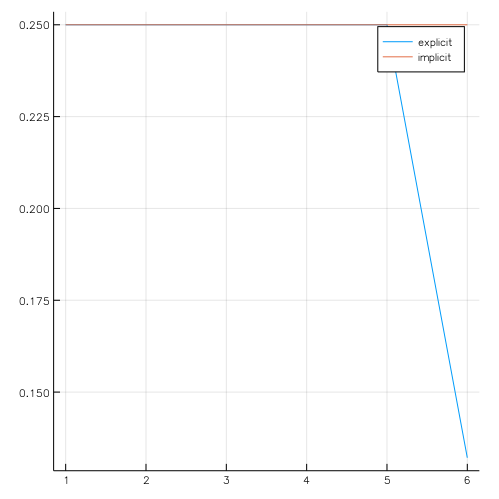

In [33]:
ts = cumsum([Δt for i in 1:N]);
j = 11
plot(traj_exp[j,:],label="explicit")
plot!(traj_imp[j,:],label="implicit")

In [17]:
traj_imp

19×6 Array{Float64,2}:
 1.0      1.0           1.0           1.0           1.0           1.0        
 0.0      3.59105e-19   7.25751e-19   1.13176e-18  -5.43275e-17  -2.39244e-15
 0.0      4.77178e-18   9.40016e-18   1.4269e-17    9.21177e-17  -1.12778e-14
 0.0      8.05305e-20   1.6599e-19    2.49716e-19   1.41401e-19   3.49408e-16
 0.0      0.00125       0.0025        0.00375       0.00379777    0.00384553 
 0.0      1.22684e-14   6.28416e-15   4.14494e-15  -4.24986e-14  -1.88465e-12
 0.0025   0.00225475    0.00176425    0.0010285     0.00175657    0.00223939 
 0.0      1.43642e-16   1.46658e-16   1.62404e-16  -2.21837e-14  -9.35246e-13
 0.0      1.90871e-15   1.85135e-15   1.94752e-15   3.11395e-14  -4.54798e-12
 0.0      3.22122e-17   3.41836e-17   3.34905e-17  -4.33259e-17   1.39706e-13
 0.25     0.25          0.25          0.25          0.00955338    0.00955338 
 0.0      2.45368e-12  -1.19684e-12  -4.27845e-13  -9.32873e-12  -3.68431e-10
 0.0     -0.04905      -0.0981       -0.1